Solving the D2 law using PINN, based on the example of PINN-ODE, https://i-systems.github.io/tutorial/KSME/CAE/220520/01_PINN.html. Details of this probelm can be found in Page 80 of the book 《燃烧学导论：概念与应用》.

$d D^2 / d t = - K $
where $K = 8 \rho D_{AB} ln(B_Y+1) / \rho_l $ 

A fuel droplet, n-dodecane, with diameter of 100 $\mu m$ is vaporizing in the dry ${N_2}$ with atmospheric pressure. 

$D_0 = 100 \mu m$, $P$ = 1 atm, $\rho_l$ = 749 kg/$m^3$, $T_s = T_{boil}$ - 10 (or 20), $\rho$ = 0.4267 kg/$m^3$. 

Parameters needed are: $T_{boil} = 489.5 K$; $h_{fg} = 256 kJ/kg$; MW_A = 170.337; $D_{AB} = 8.1 \times 10^{-6} m^2/s$ @399 K.

Derived parameters are: saturation vapor pressure at $T = T_{boil} - 10$ K solved using Clausius-Clapeyron equation, $P_{sat} = 0.7998$; $Y_{A,s} = 0.9605$ so $B_Y = 24.32$; $D_{AB} (\bar T =800 K) = 23.0 \times 10^{-6} m^2/s$.

Therefore, $K = 8 \bar \rho D_{AB} ln(B_Y+1) / \rho_l = 3.39 \times 10^{-7} m^2/s$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random

Define Network and Hyper-parameters

In [2]:
NN = tf.keras.models.Sequential([
    tf.keras.layers.Input((1,)),
    tf.keras.layers.Dense(units = 16, activation = 'tanh'),
    tf.keras.layers.Dense(units = 1)
])

NN.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49 (196.00 B)

 Trainable params: 49 (196.00 B)

 Non-trainable params: 0 (0.00 B)

In [39]:
optm = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [40]:
#normalization
u0 = 1.
K = 3.39e-7/1e-4**2
print('Initial ${D_0}^2$', u0, 'and vaporization constant ', K)

Initial ${D_0}^2$ 1.0 and vaporization constant  33.9


Define ODE system with losses(ODE loss + initial condition loss)

In [41]:
def ode_system(t, net):
    t = t.reshape(-1,1) #用于改变数组或张量的形状，将其转换为只有一列的二维数组或张量
    t = tf.constant(t, dtype = tf.float32)    #创建一个常量张量,float32类型
    t_0 = tf.zeros((1,1))
    #one = tf.ones((1,1))   
    
    with tf.GradientTape() as tape:     #在 tf.GradientTape() 的上下文中定义前向传播的计算过程，并使用 tape.watch() 方法显式地告诉 TensorFlow 跟踪某些张量的梯度信息。
        tape.watch(t)
                    
        u = net(t)
        u_t = tape.gradient(u, t)
    
    ode_loss = u_t + K 
    IC_loss = net(t_0) - u0
    
    square_loss = tf.square(ode_loss) + tf.square(IC_loss) #tf.square() 用于计算张量的平方
    total_loss = tf.reduce_mean(square_loss)  #tf.reduce_mean() 用于计算张量的均值
    
    return total_loss

在TensorFlow中，trainable_variables是一个属性，用于获取可训练变量的列表。这些可训练变量通常是神经网络中的权重和偏置，它们的值会在训练过程中通过优化算法进行更新。
optm.apply_gradients()是TensorFlow中优化器对象的一个方法，用于应用梯度更新到模型的可训练变量上。通常在训练神经网络时，我们会使用优化器对象来更新模型的参数，以最小化损失函数。

0.62744886
6.010868e-05
3.0997362e-05
3.0968175e-05
3.09643e-05
3.096479e-05
3.0968222e-05
3.0971692e-05
3.0958585e-05
3.092823e-05


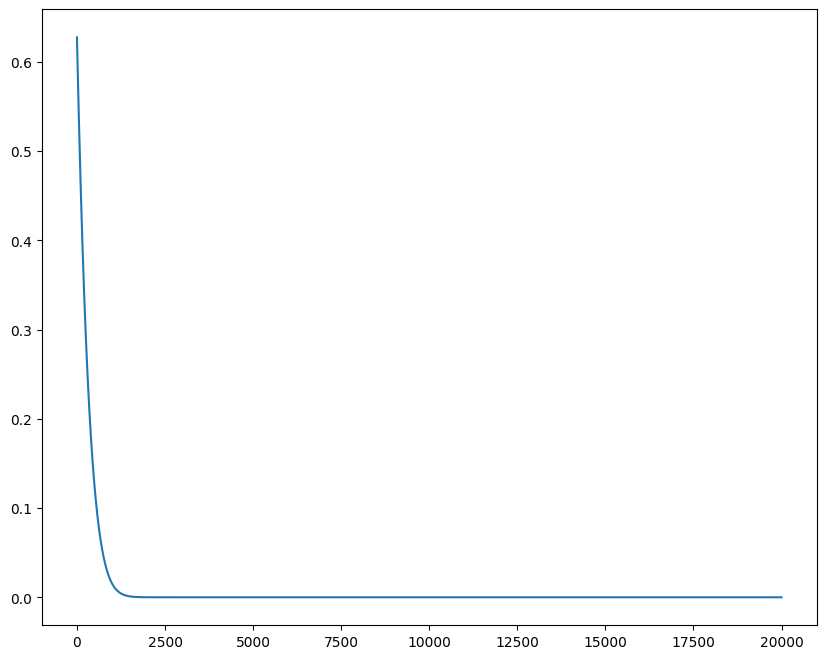

In [45]:
train_t = (np.random.rand(100)*0.03).reshape(-1, 1)
train_loss_record = []

for itr in range(20000):
    with tf.GradientTape() as tape:
        train_loss = ode_system(train_t, NN)
        train_loss_record.append(train_loss)
                
        grad_w = tape.gradient(train_loss, NN.trainable_variables)
        optm.apply_gradients(zip(grad_w, NN.trainable_variables))  #zip()用于将两个可迭代对象中对应位置的元素逐一配对组合成元组。
    
    if itr % 2000 == 0:
        print(train_loss.numpy())
        
plt.figure(figsize = (10,8))
plt.plot(train_loss_record)
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step


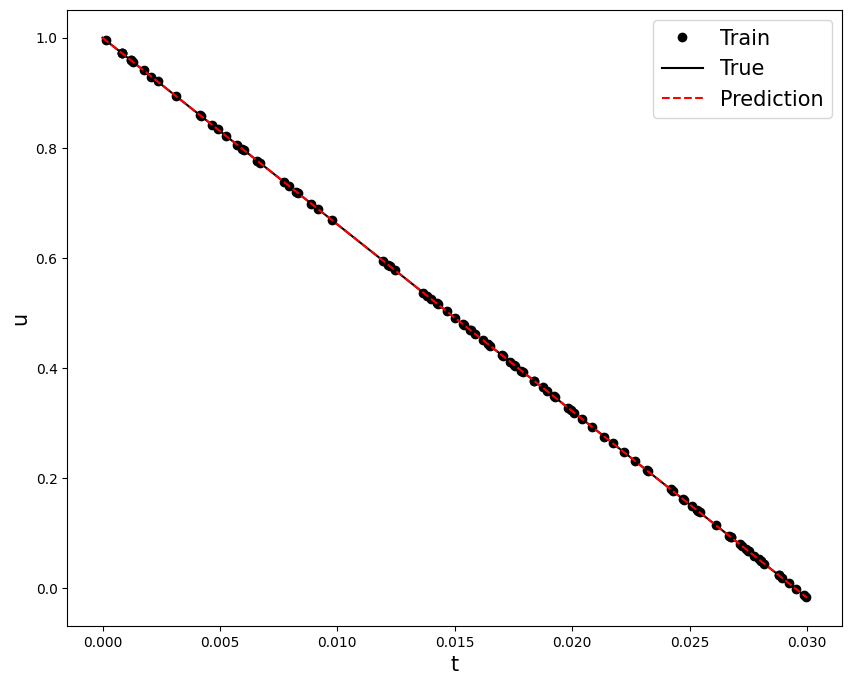

In [46]:
test_t = np.linspace(0, 0.03, 100)

train_u = u0-K*train_t
true_u = u0-K*test_t
pred_u = NN.predict(test_t).ravel()    #note this '-' symbol

plt.figure(figsize = (10,8))
plt.plot(train_t, train_u, 'ok', label = 'Train')
plt.plot(test_t, true_u, '-k',label = 'True')
plt.plot(test_t, pred_u, '--r', label = 'Prediction')
plt.legend(fontsize = 15)
plt.xlabel('t', fontsize = 15) 
plt.ylabel('u', fontsize = 15)
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step


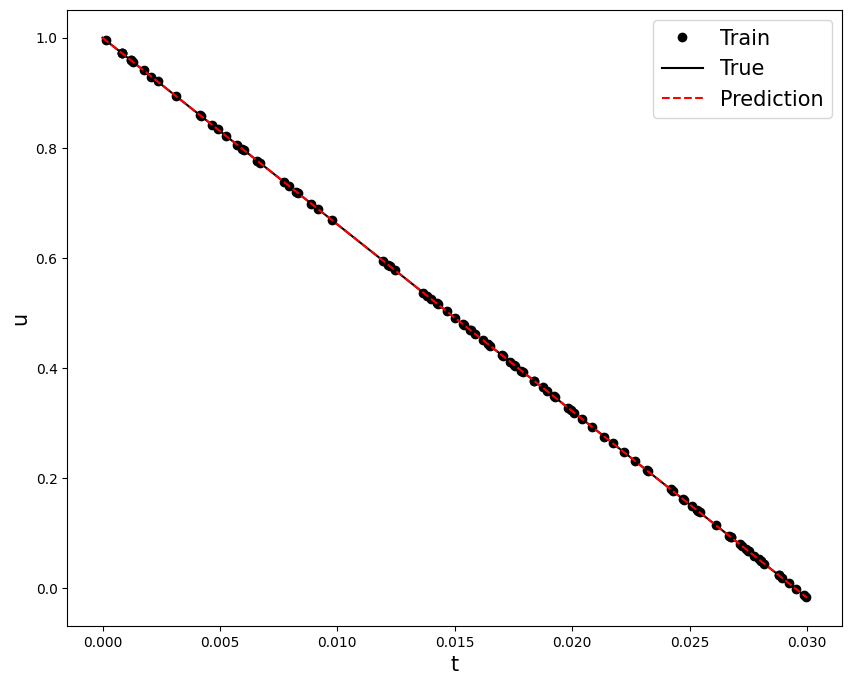

In [ ]:
test_t = np.linspace(0, 0.03, 100)

train_u = u0-K*train_t
true_u = u0-K*test_t
pred_u = NN.predict(test_t).ravel()    #note this '-' symbol

plt.figure(figsize = (10,8))
plt.plot(train_t, train_u, 'ok', label = 'Train')
plt.plot(test_t, true_u, '-k',label = 'True')
plt.plot(test_t, pred_u, '--r', label = 'Prediction')
plt.legend(fontsize = 15)
plt.xlabel('t', fontsize = 15) 
plt.ylabel('u', fontsize = 15)
plt.show()